# CMSC320 Final Tutorial - How much of an outlier are NBA MVPs?

### Made By: Sashwat Venkatesh

In most professional sports leagues, a variety of awards are typically given to a player or players following the conclusion of the season to recognize them for their outstanding play.
These awards typically include recognition for being a league's Most Valuable Player, as well as recognition for offensive and defensive performances.

These players are typically from the best teams, and there is often controversy and discussion around whether or not a particular player was truly deserving of their award.

This final tutorial aims to answer three questions:

1. Given statistics from previous award winners, can we accurately predict the same award winner of any given season?
2. Given a set of statistics, can we predict if a hypothetical player would have won a particular in any given season?
3. Are award winners typically statistical outliers based on individual statistics, or does the success of their team play a significant role in award worthiness?

Given constraints on data availability from my sources, I will be utilizing data up to the 2016-17 NBA season, and data from future seasons to present will be used as testing to validate or invalidate my guiding questions.

## Future Plan

1. Contextualize MVP seasons
    1. Standardize variables by season, show how much of an outlier MVPs are in relevant statistics
2. Understand what statistics are most likely to contribute to MVP
    1. Does team W/L play a significant role or can sheer statistical greatness overcome poor team play?
3. Build predictor/percentage likelihood for MVP awards given a set of statistics
    1. Python functions


# Code:

In [337]:
import pandas as pd
import numpy as np
import sklearn as sk
from bs4 import BeautifulSoup
from urllib.request import urlopen
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 11)
pd.set_option('display.max_columns', None)

player_data_df = pd.read_csv('datafiles/player_data.csv')
players_df = pd.read_csv('datafiles/Players.csv')
seasons_df = pd.read_csv('datafiles/Seasons_Stats.csv')

seasons_df = seasons_df.drop('Unnamed: 0', axis=1)
players_df = players_df.rename(columns={'collage': 'college'})

In [338]:
# Removing '*' from all players that had an all star season, and then marking their All-Star season in a separate column 
seasons_df['All Star Season'] = np.zeros(len(seasons_df), dtype=int)
for index, row in seasons_df.iterrows():
    
    if isinstance(row['Player'], str) == False:
        continue 
    if '*' in row['Player']:
        seasons_df.loc[index, 'Player'] = row['Player'][:len(row['Player'])-1]
        seasons_df.at[index, 'All Star Season'] += 1
    tmp = int(row['Year'])
    year = str(tmp-1) + "-" + str(int(row['Year']))[2:4]
    seasons_df.loc[index, 'Year'] = year
seasons_df['PPG'] = seasons_df['PTS']/seasons_df['G']

seasons_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All Star Season,PPG
0,1949-50,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,0,7.269841
1,1949-50,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,0,5.693878
2,1949-50,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,0,6.537313
3,1949-50,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,0,4.200000
4,1949-50,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0,0,4.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2016-17,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,17.3,12.9,9.1,1.8,3.0,10.9,15.5,NaN,3.4,2.2,5.6,0.157,NaN,-0.2,2.3,2.1,1.8,253.0,443.0,0.571,0.0,1.0,0.000,253.0,442.0,0.572,0.571,133.0,196.0,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0,0,10.306452
24687,2016-17,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,17.0,13.2,12.2,0.7,3.3,10.2,16.5,NaN,0.5,0.6,1.0,0.094,NaN,-3.2,0.8,-2.5,-0.1,78.0,158.0,0.494,0.0,1.0,0.000,78.0,157.0,0.497,0.494,22.0,39.0,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0,0,3.490196
24688,2016-17,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,NaN,-0.1,0.1,0.0,-0.005,NaN,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,0,1.210526
24689,2016-17,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,NaN,-0.3,0.8,0.5,0.030,NaN,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,5.454545


In [339]:
url = 'https://www.basketball-reference.com/awards/mvp.html'
output = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id='mvp_NBA')[0])
mvpframe = pd.read_html(output)[0]

In [340]:
# This function is used to fix the BasketballReference tables and convert them into more readable and usable DataFrames
def fix_frame(frame):
    fixed = {   'Season': frame['Unnamed: 0_level_0']['Season'], 
                    'Player': frame['Unnamed: 2_level_0']['Player'],
                    'Age': frame['Unnamed: 4_level_0']['Age'],
                    'Team': frame['Unnamed: 5_level_0']['Tm'],
                    'Games Played': frame['Unnamed: 6_level_0']['G'],
                    'MPG': frame['Per Game']['MP'],
                    'PPG': frame['Per Game']['PTS'],
                    'RPG': frame['Per Game']['TRB'],
                    'APG': frame['Per Game']['AST'],
                    'SPG': frame['Per Game']['STL'],
                    'BPG': frame['Per Game']['BLK'],
                    'FG%': frame['Shooting']['FG%'],
                    '3P%': frame['Shooting']['3P%'],
                    'FT%': frame['Shooting']['FT%'],
                    'WS': frame['Advanced']['WS'],
                    'WS/48': frame['Advanced']['WS']}
    res = pd.DataFrame(data=fixed)
    return res

In [341]:
# Showing the fixed DataFrame
mvpframe = fix_frame(mvpframe)
mvpframe


,Season,Player,Age,Team,Games Played,MPG,PPG,RPG,APG,SPG,BPG,FG%,3P%,FT%,WS,WS/48
0,2021-22,Nikola Jokić,26,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,15.2
1,2020-21,Nikola Jokić,25,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,15.6
2,2019-20,Giannis Antetokounmpo,25,MIL,63,30.4,29.5,13.6,5.6,1.0,1.0,0.553,0.304,0.633,11.1,11.1
3,2018-19,Giannis Antetokounmpo,24,MIL,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,14.4
4,2017-18,James Harden,28,HOU,72,35.4,30.4,5.4,8.8,1.8,0.7,0.449,0.367,0.858,15.4,15.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1959-60,Wilt Chamberlain,23,PHW,72,46.4,37.6,27.0,2.3,NaN,NaN,0.461,NaN,0.582,17.0,17.0
63,1958-59,Bob Pettit,26,STL,72,39.9,29.2,16.4,3.1,NaN,NaN,0.438,NaN,0.759,14.8,14.8
64,1957-58,Bill Russell,23,BOS,69,38.3,16.6,22.7,2.9,NaN,NaN,0.442,NaN,0.519,11.3,11.3
65,1956-57,Bob Cousy,28,BOS,64,36.9,20.6,4.8,7.5,NaN,NaN,0.378,NaN,0.821,8.8,8.8


In [342]:
winloss = pd.read_excel('datafiles/Historical NBA Performance.xlsx')
winloss = winloss.drop(columns=['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])
winloss['Wins'] = np.zeros(len(winloss), dtype=int)
winloss['Losses'] = np.zeros(len(winloss), dtype=int)
for index, row in winloss.iterrows():
    wl = row['Record'].split('-')
    winloss.loc[index, 'Wins'] = wl[0]
    winloss.loc[index, 'Losses'] = wl[1]
winloss = winloss.drop(columns=['Record'])
winloss

,Year,Team,Winning Percentage,Wins,Losses
0,2016-17,Celtics,0.625,25,15
1,2015-16,Celtics,0.585,48,34
2,2014-15,Celtics,0.488,40,42
3,2013-14,Celtics,0.305,25,57
4,2012-13,Celtics,0.506,41,40
...,...,...,...,...,...
1412,1965-66,Bullets,0.475,38,42
1413,1964-65,Bullets,0.463,37,43
1414,1963-64,Bullets,0.388,31,49
1415,1962-63,Zephyrs,0.313,25,55


In [343]:
teams = pd.read_json('datafiles/teams.json')
teams = teams.drop(columns=['teamId'])
teams.head()

,abbreviation,teamName,simpleName,location
0,ATL,Atlanta Hawks,Hawks,Atlanta
1,BOS,Boston Celtics,Celtics,Boston
2,BKN,Brooklyn Nets,Nets,Brooklyn
3,CHA,Charlotte Hornets,Hornets,Charlotte
4,CHI,Chicago Bulls,Bulls,Chicago


In [344]:
for index, row in winloss.iterrows():
    for index2, row2 in teams.iterrows():
        if row['Team'] == row2['simpleName']:
            winloss.loc[index, 'Team'] = row2['abbreviation']
winloss

,Year,Team,Winning Percentage,Wins,Losses
0,2016-17,BOS,0.625,25,15
1,2015-16,BOS,0.585,48,34
2,2014-15,BOS,0.488,40,42
3,2013-14,BOS,0.305,25,57
4,2012-13,BOS,0.506,41,40
...,...,...,...,...,...
1412,1965-66,Bullets,0.475,38,42
1413,1964-65,Bullets,0.463,37,43
1414,1963-64,Bullets,0.388,31,49
1415,1962-63,Zephyrs,0.313,25,55


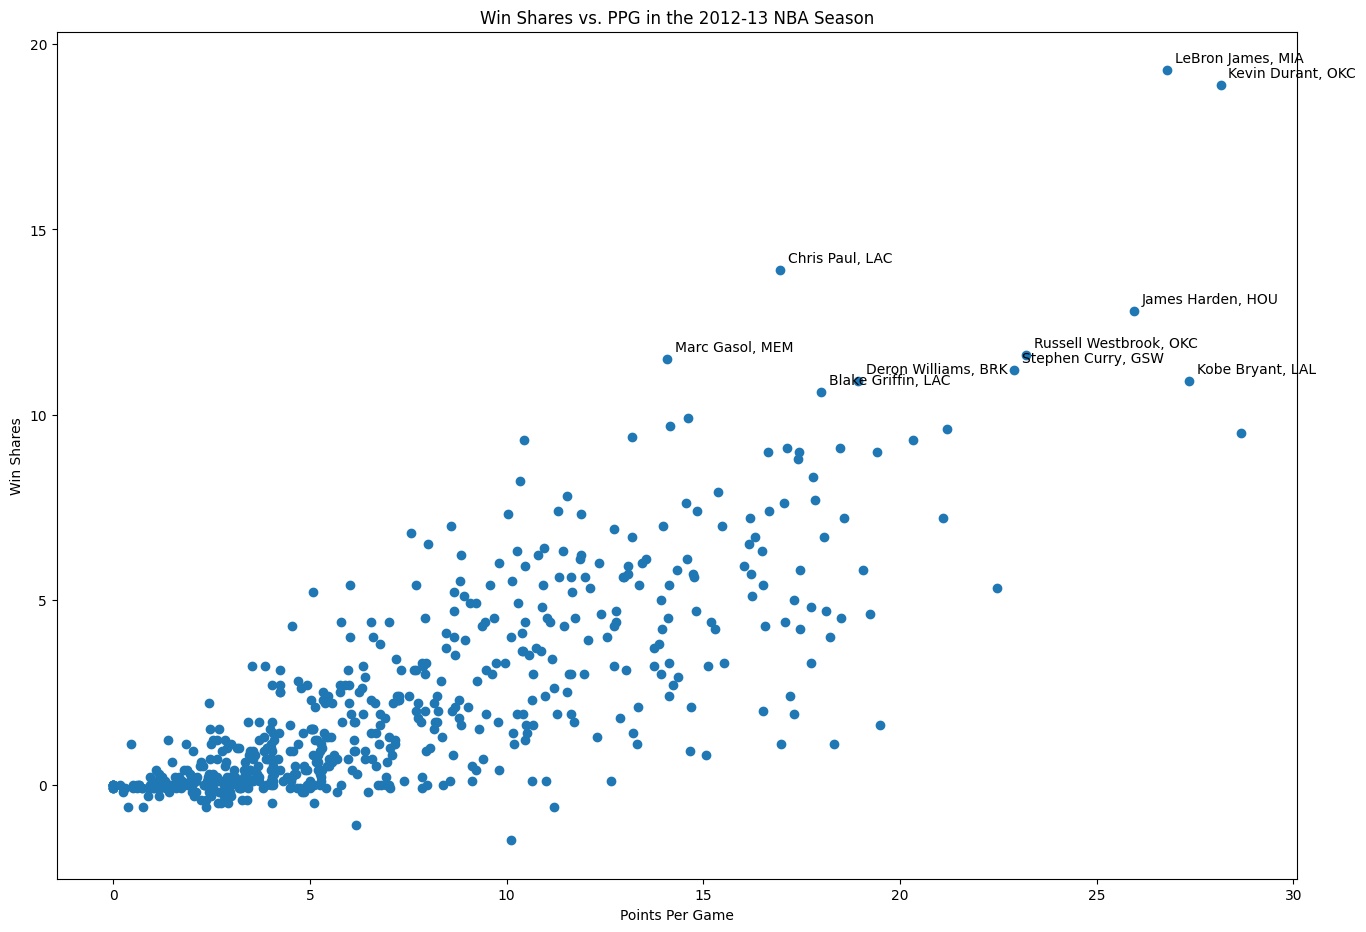

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All Star Season,PPG
21679,2012-13,Quincy Acy,PF,22.0,TOR,29.0,0.0,342.0,15.9,0.632,0.027,0.507,10.3,16.6,13.4,5.2,2.0,3.5,15.6,14.7,NaN,0.7,0.4,1.1,0.157,NaN,-0.6,1.3,0.7,0.2,42.0,75.0,0.560,1.0,2.0,0.5,41.0,73.0,0.562,0.567,31.0,38.0,0.816,30.0,47.0,77.0,11.0,13.0,15.0,17.0,53.0,116.0,0,4.000000
21680,2012-13,Jeff Adrien,PF,26.0,CHA,52.0,5.0,713.0,13.4,0.493,0.012,0.595,10.6,21.2,15.7,8.3,1.3,3.1,13.1,15.6,NaN,0.5,0.4,1.0,0.064,NaN,-3.0,-0.2,-3.3,-0.2,72.0,168.0,0.429,0.0,2.0,0.0,72.0,166.0,0.434,0.429,65.0,100.0,0.650,68.0,128.0,196.0,36.0,18.0,27.0,32.0,80.0,209.0,0,4.019231
21681,2012-13,Arron Afflalo,SF,27.0,ORL,64.0,64.0,2307.0,13.0,0.527,0.265,0.246,1.4,10.3,5.8,14.6,0.9,0.4,12.1,22.5,NaN,1.5,0.5,2.0,0.042,NaN,-0.3,-2.0,-2.3,-0.2,397.0,905.0,0.439,72.0,240.0,0.3,325.0,665.0,0.489,0.478,191.0,223.0,0.857,29.0,210.0,239.0,206.0,40.0,11.0,138.0,137.0,1057.0,0,16.515625
21682,2012-13,Josh Akognon,PG,26.0,DAL,3.0,0.0,9.0,15.3,0.625,0.500,0.000,0.0,12.1,6.2,19.4,0.0,0.0,0.0,20.3,NaN,0.0,0.0,0.0,0.196,NaN,4.7,-4.9,-0.2,0.0,2.0,4.0,0.500,1.0,2.0,0.5,1.0,2.0,0.500,0.625,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,5.0,0,1.666667
21683,2012-13,Cole Aldrich,C,24.0,TOT,45.0,0.0,388.0,11.1,0.563,0.000,0.250,8.7,26.7,17.7,3.4,0.7,4.6,20.6,12.7,NaN,0.1,0.4,0.6,0.070,NaN,-4.8,0.7,-4.0,-0.2,44.0,80.0,0.550,0.0,0.0,NaN,44.0,80.0,0.550,0.550,12.0,20.0,0.600,30.0,90.0,120.0,9.0,5.0,23.0,23.0,60.0,100.0,0,2.222222


In [345]:
test = seasons_df[seasons_df['Year'] == '2012-13']
test2 = test[test['WS'] >= 10]
plt.scatter(test['PTS']/test['G'], test['WS'])

for index, row in test.iterrows():
    if row['WS'] >= 10:
        plt.text((row['PTS']/row['G'])+0.2, row['WS'] + 0.2, row['Player'] + ", " + row['Tm'])
plt.ylabel('Win Shares')
plt.xlabel('Points Per Game')
plt.title('Win Shares vs. PPG in the 2012-13 NBA Season')
plt.show()
test.head()

The MVP of the 2012-13 NBA Season was LeBron James, who had the highest win shares over the course of the regular season. This provides an initial indication that the player who contributes the most win shares in the league each season may end up winning the NBA's MVP award. More information about Win Shares can be found here: https://www.basketball-reference.com/about/ws.html Let's check and see:

In [346]:
def matches(stat):
    matches = 0
    for index, row in mvpframe.iterrows():
        if index >= 5:
            temp = seasons_df[seasons_df['Year'] == row['Season']]
            #print('Projected MVP: ' + temp[temp['WS'] == temp['WS'].max()]['Player'].max() + ", Actual MVP: " + mvpframe.loc[index, 'Player'])
            if temp[temp[stat] == temp[stat].max()]['Player'].max() == mvpframe.loc[index, 'Player']:
                matches += 1
    return (str(matches) + " matches from " + str(len(mvpframe)) + " MVPs")

In [347]:
matches('WS')


'33 matches from 67 MVPs'

As we can see from a quick check, amongst the 67 seasons that overlap between my two datasets, 33/67, or 49.25% of MVPs were the player who had the highest Win Share stat in the league that given year. In a general sense, picking approximately 1 out of every 2 MVPs is no better than flipping a coin, so let's see if we can do any better than just the Win Share method, by using examining and combining some other key statistics.

First, let's see if guessing the top scorer, measured by Points Per Game, provides a more accurate guess:

In [348]:
matches('PPG')

'17 matches from 67 MVPs'

PPG didn't give us a good return, at just 17/67, or just over 25% of correct matches. Let's check another stat, known as Value Over Replacement Player:

VORP is defined as: Value Over Replacement Player (available since the 1973-74 season in the NBA); a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season.

Above definition from: https://www.basketball-reference.com/about/glossary.html

In [349]:
matches('VORP')

'25 matches from 67 MVPs'

VORP gives us odds right in between PPG and WS, but still only correctly matches 37% of MVPs. Let's take a look at one more statistic, called the Player Efficiency Rating. More information on PER can be found here: https://en.wikipedia.org/wiki/Player_efficiency_rating

In [350]:
matches('PER')

'13 matches from 67 MVPs'

Surprisingly, PER, an advanced stat created to combine all of a player's contributions into one number, has the worst prediction/guess rate of the 4 metrics one might easily think an MVP would lead in. However, with specific regards to PER, the use of this stat as a predictor is slightly flawed, since it is heavily impacted by the numerous rule changes that the NBA has gone through over the decades of its existence.

Now, instead of being a leader, maybe being a significant statistical outlier in these stats lends a player to being an MVP candidate. Let's examine:

LeBron James's standardized PPG in the 2012-13 season was: 3.596791023912511


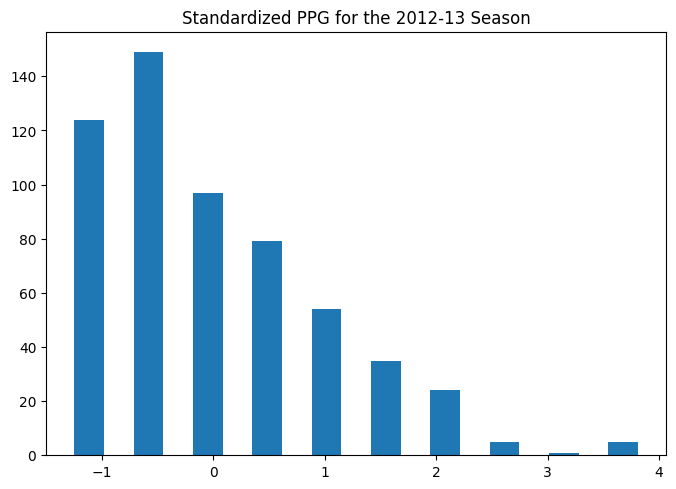

In [351]:
plt.rcParams["figure.figsize"] = (8, 5.5)
def grapher(stat, year):
    mvp = mvpframe[mvpframe['Season'] == year]['Player'].max()
    year_stat = seasons_df[seasons_df['Year'] == year]
    meanstat = np.mean(year_stat[stat])
    stdstat = np.std(year_stat[stat])
    standardized = [(i - meanstat)/stdstat for i in year_stat[stat]]
    mvp_stat = year_stat.loc[year_stat['Player'] == mvp]
    print(mvp + "'s standardized " + str(stat) + " in the " + str(year) + " season was: " + str(((mvp_stat[stat]-meanstat)/stdstat).max()))
    plt.hist(standardized, rwidth=0.5)
    plt.title('Standardized ' + str(stat) + ' for the ' + str(year) + " Season")
    plt.show()



grapher('PPG', '2012-13')